<a href="https://colab.research.google.com/github/ChristinaKou/Congitive-/blob/Dataset/CognvitivePlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Initialisation and function definitions**

Import modules

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import tarfile
from random import randrange
from keras import layers


Paths

In [569]:
# Project directory
workingDir = '/Cognitive'
# Make a project folder if not existent
if not os.path.exists(workingDir):
    os.makedirs(workingDir)
os.chdir(workingDir) # Cd to this foder 
print("The current workig directory is",os.getcwd()[1:] )

The current workig directory is Cognitive


Functions

In [0]:
# List non hidden files in current folder
def nonHiddenfiles():
  fileList = [n_file for n_file in os.listdir() if not n_file.startswith('.')] 
  return fileList

# Unpickle file
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict


# **2. Data Loading and preprocessing**



## 2.1 Download and decompress dataset

In [571]:
# Download dataset if not already downloaded
fileList = nonHiddenfiles()
if len(fileList)==0: # Check for non hidden files
  # Donwload 
  print("Downloading data ..")
  !wget -q --show-progress https://www.cs.toronto.edu/%7Ekriz/cifar-100-python.tar.gz
  fileList = nonHiddenfiles()
  print("Dataset", fileList[-1],  "downloaded" )
else:
  # Do not download
  print("Dataset", fileList[-1], "already downloaded" )
  fileList = nonHiddenfiles()

Dataset cifar-100-python already downloaded


In [572]:
# Decompress dataset
fileList = nonHiddenfiles()
datasetFile = fileList[-1]
if datasetFile.endswith("tar.gz"):
  print("Decompressing dataset..")    
  tar = tarfile.open(datasetFile, "r:gz")    
  tar.extractall()
  tar.close()
  print("..into", tar.name)
  os.remove(tar.name) # delete compressed file
  fileList.remove(datasetFile)
else:
  print("Dataset uncompressed") 


Dataset uncompressed


## 2.2 Explore dataset

In [0]:
# Look into the folder
os.chdir(tar.members[0].name) 
# List non hidden content
contentList = nonHiddenfiles()
print(*contentList, sep = "\n")
%cd ..

In [0]:
# Unpickle data 
os.chdir(tar.members[0].name)
test = unpickle(contentList[0])
meta = unpickle(contentList[1])
train = unpickle(contentList[3])
print(type(test), type(meta), type(train))
%cd ..

### Table of dataset summary 

In [0]:
print("\tLABEL","\t\t\t","LENGTH\t\t", "VALUE")

# expore meta dataset
print("META")
for i in list(range(0,len(meta))):
  print(list(meta.keys())[i],"\t\t",len(list(test.values())[i]),"\t\t",list(meta.values())[i]), print('\n')

# expore train dataset
print("TRAIN")
for i in list(range(0,len(train))):
  print(list(train.keys())[i],"      \t\t",len(list(train.values())[i]),"\t\t",list(train.values())[i]), print('\n')

# expore test dataset
print("TEST")
for i in list(range(0,len(test))):
  print(list(test.keys())[i],":          \t",len(list(test.values())[i]),"\t\t", list(test.values())[i]), print('\n')


### Image examples

In [0]:
# type and shape of image data
print(type(train[b'data']),train[b'data'].shape)


In [676]:
# reshape dataset
trainImages = train[b'data'].reshape(50000,3,32,32).transpose(2,3,1,0);
trainImages.shape

(32, 32, 3, 50000)

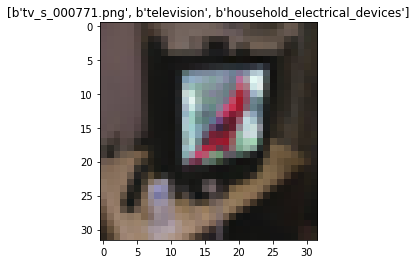

In [688]:
# Show random image examples with their filename, coarse category and fine category
%matplotlib inline
thisImage=randrange(len(train[b'filenames']));
plt.imshow(trainImages[:,:,:,thisImage].squeeze());
plt.title([train[b'filenames'][thisImage], meta[b'fine_label_names'][train[b'fine_labels'][thisImage]],meta[b'coarse_label_names'][train[b'coarse_labels'][thisImage]]] );
